# Wariant 3: Różnica dwóch liczb 32-bitowych
## Rekurencyjna Sieć Neuronowa z Operacjami Tensorowymi

Implementacja rekurencyjnej sieci neuronowej (RNN) do nauki operacji odejmowania na liczbach binarnych 32-bitowych. Sieć uczy się sekwencyjnie przetwarzać bity liczb, obliczając różnicę bit po bicie.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)

## 1. Przygotowanie Danych

Utworzenie zbióru danych zawierający pary liczb 32-bitowych i ich różnicę. Każda liczba jest reprezentowana w postaci binarnej, z bitami ułożonymi od najmniej znaczącego (LSB) do najbardziej znaczącego (MSB).

In [6]:
def create_dataset(nb_samples, sequence_len):
    # maksymalna wartość dla liczby całkowitej bez znaku o długości sequence_len bitów
    max_int = 2**(sequence_len)
    
    # Wygeneruj losowe liczby całkowite, gdzie X1 >= X2, aby uniknąć wyników ujemnych
    # dla 32-bit: od 0 do 2^32-1
    X1 = np.random.randint(0, max_int, size=nb_samples, dtype=np.int64)
    X2 = np.random.randint(0, max_int, size=nb_samples, dtype=np.int64)
    
    X1, X2 = np.maximum(X1, X2), np.minimum(X1, X2)
    
    # Oblicz różnicę
    T_int = X1 - X2
    
    X = np.zeros((nb_samples, sequence_len, 2))
    T = np.zeros((nb_samples, sequence_len, 1))
    
    # Przekształć liczby na reprezentacje binarne i wypełnij tensory
    for i in range(nb_samples):
        x1_binary = format(X1[i], f'0{sequence_len}b')
        x2_binary = format(X2[i], f'0{sequence_len}b')
        t_binary = format(T_int[i], f'0{sequence_len}b')
        
        # odwróć ciągi, aby LSB było pierwsze
        x1_binary = x1_binary[::-1]
        x2_binary = x2_binary[::-1]
        t_binary = t_binary[::-1]
        
        for j in range(sequence_len):
            X[i, j, 0] = int(x1_binary[j])
            X[i, j, 1] = int(x2_binary[j])
            T[i, j, 0] = int(t_binary[j])
    
    return X, T


sequence_len = 32  
nb_train = 2000   
nb_test = 100      


print("Tworzenie zbioru treningowego (2000 próbek odejmowania 32-bitowego)...")
X_train, T_train = create_dataset(nb_train, sequence_len)
print(f"X_train shape: {X_train.shape}")
print(f"T_train shape: {T_train.shape}")

print("\nTworzenie zbioru testowego (100 próbek odejmowania 32-bitowego)...")
X_test, T_test = create_dataset(nb_test, sequence_len)
print(f"X_test shape: {X_test.shape}")
print(f"T_test shape: {T_test.shape}")

Tworzenie zbioru treningowego (2000 próbek odejmowania 32-bitowego)...
X_train shape: (2000, 32, 2)
T_train shape: (2000, 32, 1)

Tworzenie zbioru testowego (100 próbek odejmowania 32-bitowego)...
X_test shape: (100, 32, 2)
T_test shape: (100, 32, 1)


In [ ]:
def print_binary_operation(x1_binary, x2_binary, target_binary, output_binary):
    # odwróć ciągi, aby LSB było pierwsze
    x1_str = x1_binary[::-1]
    x2_str = x2_binary[::-1]
    t_str = target_binary[::-1]
    o_str = output_binary[::-1]
    
    # przekonwertuj na dziesiętne dla weryfikacji
    x1_dec = int(x1_str, 2)
    x2_dec = int(x2_str, 2)
    t_dec = int(t_str, 2)
    o_dec = int(o_str, 2)
    
    print(f"Input 1 (X1):      {x1_str} (decimal: {x1_dec})")
    print(f"Input 2 (X2):      {x2_str} (decimal: {x2_dec})")
    print(f"Expected (X1-X2):  {t_str} (decimal: {t_dec})")
    print(f"Network output:    {o_str} (decimal: {o_dec})")
    print(f"Match: {t_dec == o_dec}")

# testowe przykłady odejmowania
print("\n" + "="*60)
print("Przykłady odejmowania z zestawu treningowego:")
print("="*60)
for i in range(3):
    x1_bin = ''.join(str(int(X_train[i, j, 0])) for j in range(sequence_len))
    x2_bin = ''.join(str(int(X_train[i, j, 1])) for j in range(sequence_len))
    t_bin = ''.join(str(int(T_train[i, j, 0])) for j in range(sequence_len))
    print(f"\Przykład {i+1}:")
    print_binary_operation(x1_bin, x2_bin, t_bin, t_bin)
    print()


Example binary subtraction operations:

Example 1:
Input 1 (X1):      01011111111000011101110001100110 (decimal: 1608637542)
Input 2 (X2):      00101111011001001101111100101110 (decimal: 795139886)
Expected (X1-X2):  00110000011111001111110100111000 (decimal: 813497656)
Network output:    00110000011111001111110100111000 (decimal: 813497656)
Match: True


Example 2:
Input 1 (X1):      11001011111010100011110110110011 (decimal: 3421126067)
Input 2 (X2):      00010110001100100101000000001011 (decimal: 372396043)
Expected (X1-X2):  10110101101101111110110110101000 (decimal: 3048730024)
Network output:    10110101101101111110110110101000 (decimal: 3048730024)
Match: True


Example 3:
Input 1 (X1):      11110011011000100000001101011100 (decimal: 4083286876)
Input 2 (X2):      10001010101110100000010100111101 (decimal: 2327446845)
Expected (X1-X2):  01101000101001111111111000011111 (decimal: 1755840031)
Network output:    01101000101001111111111000011111 (decimal: 1755840031)
Match: True



## 2. Architektura Sieci Neuronowej

Implementacja modułową architekturę RNN z następującymi komponentami:
- **TensorLinear**: Liniowa transformacja tensorowa (tensor dot product)
- **LogisticClassifier**: Sigmoid + Binary Cross-Entropy loss
- **TanH**: Funkcja aktywacji tanh
- **RecurrentStateUpdate**: Pojedynczy krok rekurencji z nonlinearnością
- **RecurrentStateUnfold**: Rozwijanie stanów przez czas (BPTT)
- **RnnBinarySubtractor**: Pełna sieć dla odejmowania binarnego

In [8]:
class TensorLinear(object):
    """liniowa transformacja warstwy przy użyciu iloczynu tensorowego."""
    
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        """Inicjalizacja warstwy liniowej tensora. """
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        """Przeprowadź krok w przód transformacji z iloczynem tensorowym."""
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """Prowadź wsteczną propagację gradientu przez warstwę."""
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB


class LogisticClassifier(object):
    """logistyczna warstwa z funkcją aktywacji sigmoid i stratą BCE."""
   
    def forward(self, X):
        """Zastosuj funkcję aktywacji sigmoid."""
        return 1. / (1. + np.exp(-X))
    
    def backward(self, Y, T):
        """prowadź wsteczną propagację przez warstwę logistyczną. """
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y, T):
        """Oblicz stratę Binary Cross-Entropy."""
        
        epsilon = 1e-10
        Y = np.clip(Y, epsilon, 1 - epsilon)
        return -np.mean((T * np.log(Y)) + ((1-T) * np.log(1-Y)))


# zdefiniuj warstwę aktywacji TanH
class TanH(object):
    """funkcja aktywacji TanH."""
    
    def forward(self, X):
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)


# Zdefiniuj pojedynczy krok aktualizacji stanu rekurencyjnego
class RecurrentStateUpdate(object):
    
    
    def __init__(self, nbStates, W, b):
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """oblicz aktualizację stanu rekurencyjnego. """
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Prowadź wsteczną propagację przez krok aktualizacji stanu rekurencyjnego.
        """
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB


# Zdefiniuj warstwę rozwijania stanów rekurencyjnych w czasie
class RecurrentStateUnfold(object):
    
    def __init__(self, nbStates, nbTimesteps):
        """inicjalizuj parametry RNN. """
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))
        self.S0 = np.zeros(nbStates)  
        self.nbTimesteps = nbTimesteps
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)
        
    def forward(self, X):
        """propagacja w przód przez czas. """
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0
        for k in range(self.nbTimesteps):
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """propagacja wsteczna przez czas."""
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)
        gBSum = np.zeros_like(self.b)
        
        for k in range(self.nbTimesteps-1, -1, -1):
            gSk += gY[:,k,:]
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW
            gBSum += gB
        
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0


# zdefiniuj architekturę RNN do odejmowania binarnego
class RnnBinarySubtractor(object):
   
    
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, 
                 sequence_len):
        # warstwa wejściowa: projektuj wejścia do przestrzeni stanów
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # warstwa rekurencyjna: rozwijaj stany w czasie
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # warstwa wyjściowa: projektuj stany do przestrzeni wyjściowej
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifier()
        
    def forward(self, X):
        """propagacja w przód przez wszystkie warstwy."""
        recIn = self.tensorInput.forward(X)
        S = self.rnnUnfold.forward(recIn)
        Z = self.tensorOutput.forward(S[:,1:sequence_len+1,:])
        Y = self.classifier.forward(Z)
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """propagacja wsteczna przez wszystkie warstwy."""
        gZ = self.classifier.backward(Y, T)
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:sequence_len+1,:], gZ)
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        recIn, S, Z, Y = self.forward(X)
        return Y
    
    def getBinaryOutput(self, X):
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        """Gradienty parametrów sieci."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y, T):
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self):
        """Zwróć iterator po wszystkich parametrach sieci """
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))



## 3. Weryfikacja Gradientów

Sprawdzamy poprawność obliczeń gradientów poprzez porównanie gradientów analitycznych (z backpropagation) z gradientami numerycznymi.

In [9]:
print("Inicjalizacja RNN do weryfikacji gradientów...")
RNN_check = RnnBinarySubtractor(2, 1, 3, sequence_len)

print("obliczenie gradientów z backprop na partii 50 próbek...")
backprop_grads = RNN_check.getParamGrads(
    X_train[0:50,:,:], T_train[0:50,:,:])

eps = 1e-7  
checked_count = 0
max_to_check = 20  

print("\nWeryfikacja gradientów (sprawdzanie pierwszych 20 parametrów)...")
for p_idx, param in enumerate(RNN_check.get_params_iter()):
    if checked_count >= max_to_check:
        break
    
    grad_backprop = backprop_grads[p_idx]
    
    # numeryczne przybliżenie gradientu
    param_val_orig = param.copy()
    
    param += eps
    plus_loss = RNN_check.loss(
        RNN_check.getOutput(X_train[0:50,:,:]), T_train[0:50,:,:])
    
    param -= 2 * eps
    minus_loss = RNN_check.loss(
        RNN_check.getOutput(X_train[0:50,:,:]), T_train[0:50,:,:])
    
    param += eps  
    
    grad_num = (plus_loss - minus_loss) / (2*eps)
    
    # Check if close
    if not np.isclose(grad_num, grad_backprop, rtol=1e-2, atol=1e-4):
        print(f"Warning: Parameter {p_idx}: numerical={grad_num:.8f}, backprop={grad_backprop:.8f}")
    else:
        if checked_count < 5:
            print(f"✓ Parameter {p_idx}: gradients match (numerical={grad_num:.8f})")
    
    checked_count += 1

print(f"\nWeryfikacja gradientów zakończona ({checked_count} parametrów sprawdzonych)")


Inicjalizacja RNN do weryfikacji gradientów...
obliczenie gradientów z backprop na partii 50 próbek...

Weryfikacja gradientów (sprawdzanie pierwszych 20 parametrów)...
✓ Parameter 0: gradients match (numerical=0.00574286)
✓ Parameter 1: gradients match (numerical=0.00337191)
✓ Parameter 2: gradients match (numerical=-0.00130995)
✓ Parameter 3: gradients match (numerical=0.00777844)
✓ Parameter 4: gradients match (numerical=0.01586493)

Weryfikacja gradientów zakończona (20 parametrów sprawdzonych)


## 4. Trening Sieci

Trenujemy sieć za pomocą algorytmu RMSProp z przyspieszonym gradientem Nesterova. Algorytm optymalizuje parametry sieci, aby nauczyć się wykonywania odejmowania binarnego.

In [10]:
# hiperparametry treningu
lmbd = 0.5  # RMSProp lambda 
learning_rate = 0.05  # Learning rate
momentum_term = 0.80  # Nesterov momentum
eps = 1e-6  # numeryczna stabilność dla RMSProp
mb_size = 100  # LIczba próbek w minibatchu
nb_epochs = 10  # liczba epok treningu

print("Inicjalizacja RNN do odejmowania binarnego...")
nb_of_states = 3  
RNN = RnnBinarySubtractor(2, 1, nb_of_states, sequence_len)

# inicjalizacja zmiennych optymalizatora
nbParameters = sum(1 for _ in RNN.get_params_iter())
maSquare = [0.0 for _ in range(nbParameters)]  
Vs = [0.0 for _ in range(nbParameters)]  

print(f"całkowita liczba parametrów sieci: {nbParameters}")
print(f"Trening przez {nb_epochs} epok z minibatch size {mb_size}")
print(f"Epochy treningowe: {nb_train // mb_size} minibatchy każda")

# Start training
ls_of_loss = [RNN.loss(RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])]
iteration_count = 0

print("\nStart treningu...\n")
for epoch in range(nb_epochs):
    nb_train_iter = nb_train // mb_size
    
    for mb in range(nb_train_iter):
        X_mb = X_train[mb*mb_size:(mb+1)*mb_size,:,:]
        T_mb = T_train[mb*mb_size:(mb+1)*mb_size,:,:]
        
        # Nesterov momentum: oblicz tymczasowe prędkości
        V_tmp = [v * momentum_term for v in Vs]
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        
        # gradienty po zastosowaniu momentum
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)
        
        # zaaktualizuj każdy parametr używając RMSProp z Nesterov momentum
        for pIdx, P in enumerate(RNN.get_params_iter()):
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (1-lmbd) * backprop_grads[pIdx]**2
            
            pGradNorm = ((learning_rate * backprop_grads[pIdx]) / 
                        (np.sqrt(maSquare[pIdx]) + eps))
            
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm
            
            P -= pGradNorm
        
        # Sledź stratę
        current_loss = RNN.loss(RNN.getOutput(X_mb), T_mb)
        ls_of_loss.append(current_loss)
        iteration_count += 1
        
        if (mb + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{nb_epochs}, Batch {mb+1}/{nb_train_iter}, Loss: {current_loss:.6f}")
    
    # Podsumowanie epoki
    train_loss = RNN.loss(RNN.getOutput(X_train), T_train)
    test_loss = RNN.loss(RNN.getOutput(X_test), T_test)
    print(f"\n  → Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}\n")

print("\nTrening zakończony!")
print(f"Ostateczna strata: {ls_of_loss[-1]:.6f}")
print(f"Całkowita iłość iteracji: {iteration_count}")

Inicjalizacja RNN do odejmowania binarnego...
całkowita liczba parametrów sieci: 28
Trening przez 10 epok z minibatch size 100
Epochy treningowe: 20 minibatchy każda

Start treningu...

Epoch 1/10, Batch 5/20, Loss: 0.683232
Epoch 1/10, Batch 10/20, Loss: 0.662864
Epoch 1/10, Batch 15/20, Loss: 0.622190
Epoch 1/10, Batch 20/20, Loss: 0.508157

  → Epoch 1: Train Loss = 0.508635, Test Loss = 0.511408

Epoch 2/10, Batch 5/20, Loss: 0.360963
Epoch 2/10, Batch 10/20, Loss: 0.258056
Epoch 2/10, Batch 15/20, Loss: 0.193718

  → Epoch 1: Train Loss = 0.508635, Test Loss = 0.511408

Epoch 2/10, Batch 5/20, Loss: 0.360963
Epoch 2/10, Batch 10/20, Loss: 0.258056
Epoch 2/10, Batch 15/20, Loss: 0.193718
Epoch 2/10, Batch 20/20, Loss: 0.162370

  → Epoch 2: Train Loss = 0.164017, Test Loss = 0.167570

Epoch 2/10, Batch 20/20, Loss: 0.162370

  → Epoch 2: Train Loss = 0.164017, Test Loss = 0.167570

Epoch 3/10, Batch 5/20, Loss: 0.147650
Epoch 3/10, Batch 10/20, Loss: 0.162363
Epoch 3/10, Batch 15/2

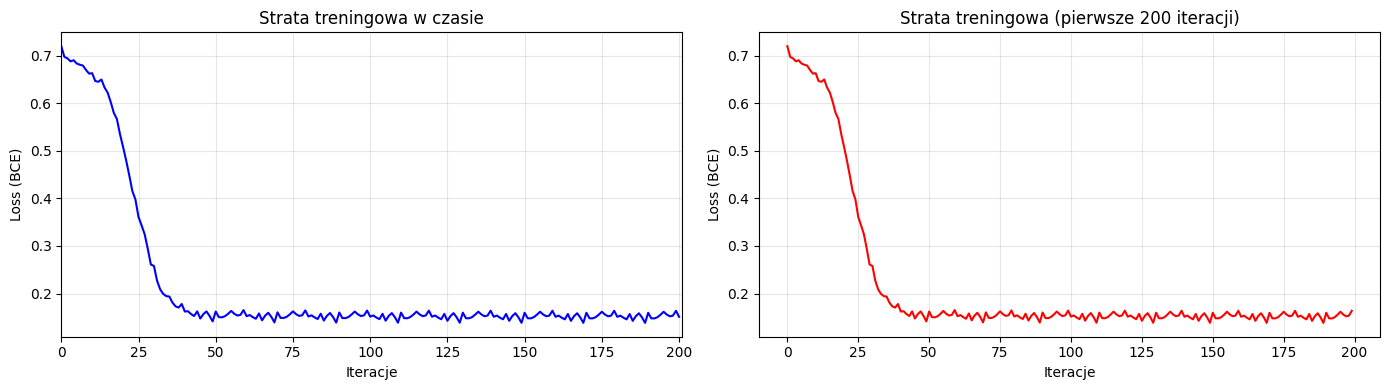

Historia Straty: min=0.138494, max=0.719633
Strata ostateczna: 0.151194


In [11]:
# Wizualizacja krzywej straty
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1: krzywa straty
axes[0].plot(ls_of_loss, 'b-', linewidth=1.5)
axes[0].set_xlabel('Iteracje')
axes[0].set_ylabel('Loss (BCE)')
axes[0].set_title('Strata treningowa w czasie')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, len(ls_of_loss))

# Plot 2: krzywa straty - zoom na pierwsze 200 iteracji
axes[1].plot(ls_of_loss[:min(200, len(ls_of_loss))], 'r-', linewidth=1.5)
axes[1].set_xlabel('Iteracje')
axes[1].set_ylabel('Loss (BCE)')
axes[1].set_title('Strata treningowa (pierwsze 200 iteracji)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Historia Straty: min={min(ls_of_loss):.6f}, max={max(ls_of_loss):.6f}")
print(f"Strata ostateczna: {ls_of_loss[-1]:.6f}")

## 5. Testowanie Operacji Odejmowania

In [12]:
print("Testowanie RNN na zbiorze testowym...")

Y_test_soft = RNN.getOutput(X_test)
Y_test_binary = RNN.getBinaryOutput(X_test)

for i in range(min(5, X_test.shape[0])):
    x1_bin = ''.join(str(int(X_test[i, j, 0])) for j in range(sequence_len))
    x2_bin = ''.join(str(int(X_test[i, j, 1])) for j in range(sequence_len))
    t_bin = ''.join(str(int(T_test[i, j, 0])) for j in range(sequence_len))
    y_bin = ''.join(str(int(Y_test_binary[i, j, 0])) for j in range(sequence_len))
    
    print(f"\nPrzykłady {i+1}:")
    print_binary_operation(x1_bin, x2_bin, t_bin, y_bin)
    print()

Testowanie RNN na zbiorze testowym...

Przykłady 1:
Input 1 (X1):      01110101010100110011000011000101 (decimal: 1968386245)
Input 2 (X2):      01000010111111110010010011011011 (decimal: 1124017371)
Expected (X1-X2):  00110010010101000000101111101010 (decimal: 844368874)
Network output:    00110010111111000000111111111010 (decimal: 855379962)
Match: False


Przykłady 2:
Input 1 (X1):      11011000110011111010101001100001 (decimal: 3637488225)
Input 2 (X2):      01000110100101011001001110000110 (decimal: 1184207750)
Expected (X1-X2):  10010010001110100001011011011011 (decimal: 2453280475)
Network output:    10010110001110100001011111011111 (decimal: 2520389599)
Match: False


Przykłady 3:
Input 1 (X1):      01111100000101010000111001000000 (decimal: 2081754688)
Input 2 (X2):      00111111001110100000000010100010 (decimal: 1060765858)
Expected (X1-X2):  00111100110110110000110110011110 (decimal: 1020988830)
Network output:    00111111111110110000110110111110 (decimal: 1073417662)
Match:

## 6. Ewaluacja Wyników

Analiza dokładność sieci na zbiorze treningowym i testowym. Należy obliczyć procent poprawnie odtworzonych bitów i całych operacji.

In [13]:
print("EWALUACJA WYNIKÓW - DOKŁADNOŚĆ SIECI")

Y_train_binary = RNN.getBinaryOutput(X_train)
Y_test_binary = RNN.getBinaryOutput(X_test)

train_bit_accuracy = np.mean(Y_train_binary == T_train)
test_bit_accuracy = np.mean(Y_test_binary == T_test)

print(f"\nDokładność na poziomie bitów:")
print(f"  Training set: {train_bit_accuracy*100:.2f}%")
print(f"  Test set:     {test_bit_accuracy*100:.2f}%")

train_seq_correct = np.all(Y_train_binary == T_train, axis=(1, 2))
test_seq_correct = np.all(Y_test_binary == T_test, axis=(1, 2))

train_seq_accuracy = np.mean(train_seq_correct)
test_seq_accuracy = np.mean(test_seq_correct)

print(f"\nDokładność na poziomie sekwencji (cała operacja poprawna):")
print(f"  Training set: {train_seq_accuracy*100:.2f}% ({np.sum(train_seq_correct)}/{len(train_seq_correct)} operacji)")
print(f"  Test set:     {test_seq_accuracy*100:.2f}% ({np.sum(test_seq_correct)}/{len(test_seq_correct)} operacji)")

# strata na zbiorze treningowym i testowym
train_loss = RNN.loss(RNN.getOutput(X_train), T_train)
test_loss = RNN.loss(RNN.getOutput(X_test), T_test)

print(f"\nStrata (Binary Cross-Entropy):")
print(f"  Training set: {train_loss:.6f}")
print(f"  Test set:     {test_loss:.6f}")

train_errors = np.sum(Y_train_binary != T_train)
test_errors = np.sum(Y_test_binary != T_test)

print(f"\nLiczba błędnych bitów:")
print(f"  Training set: {train_errors} / {Y_train_binary.size} ({train_errors/Y_train_binary.size*100:.2f}%)")
print(f"  Test set:     {test_errors} / {Y_test_binary.size} ({test_errors/Y_test_binary.size*100:.2f}%)")

EWALUACJA WYNIKÓW - DOKŁADNOŚĆ SIECI

Dokładność na poziomie bitów:
  Training set: 89.10%
  Test set:     88.28%

Dokładność na poziomie sekwencji (cała operacja poprawna):
  Training set: 5.90% (118/2000 operacji)
  Test set:     3.00% (3/100 operacji)

Strata (Binary Cross-Entropy):
  Training set: 0.153211
  Test set:     0.157018

Liczba błędnych bitów:
  Training set: 6979 / 64000 (10.90%)
  Test set:     375 / 3200 (11.72%)


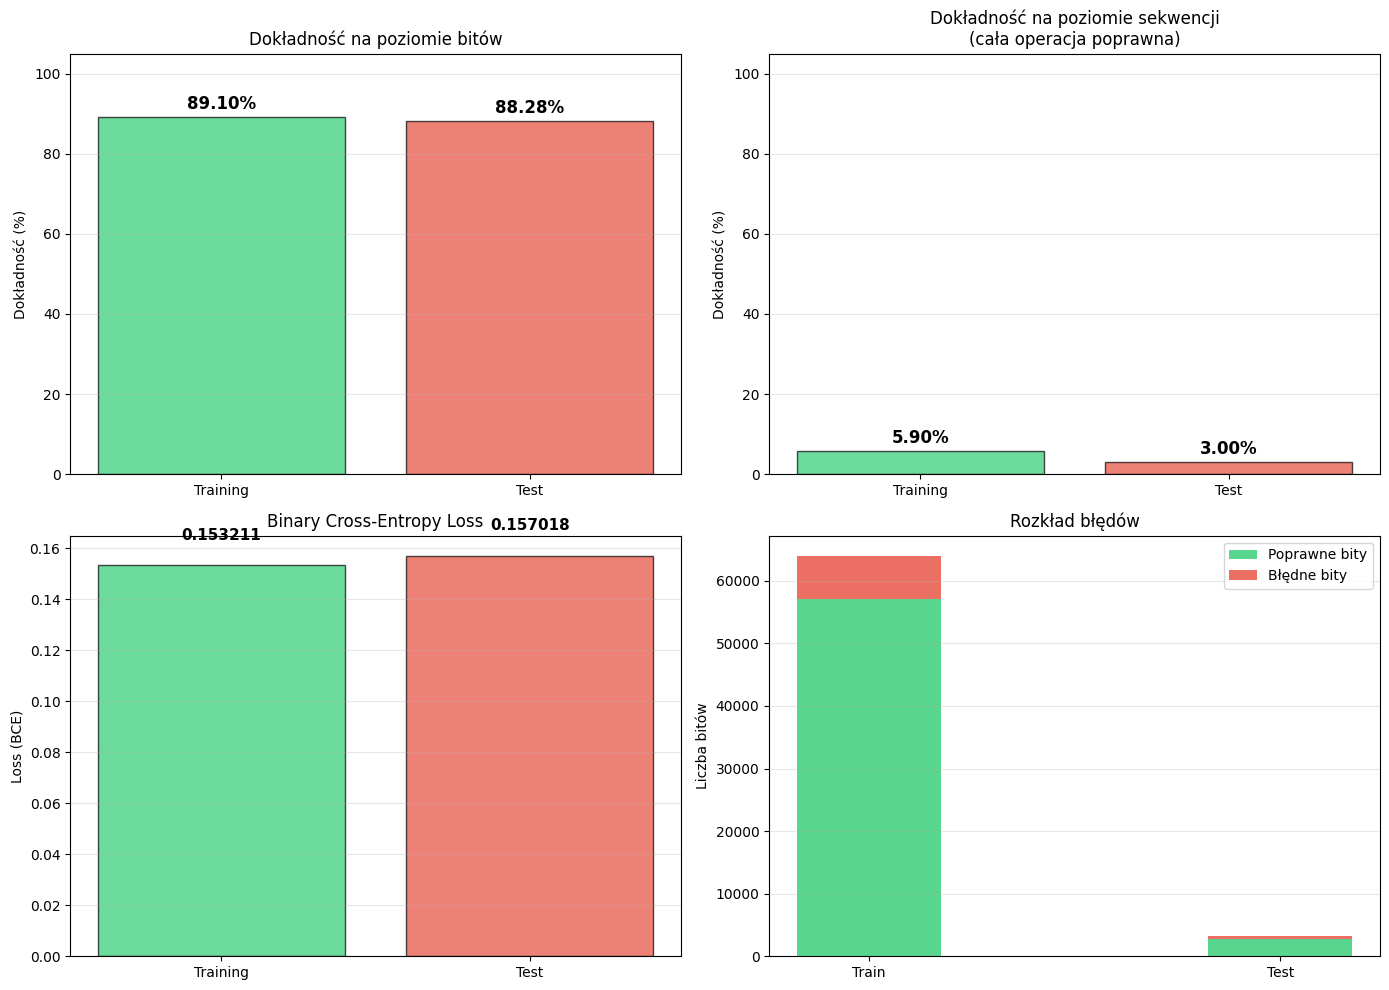

In [14]:
# Wizualizacja wyników ewaluacji
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: bit-level dokładność porównanie
categories = ['Training', 'Test']
bit_accs = [train_bit_accuracy*100, test_bit_accuracy*100]
colors = ['#2ecc71', '#e74c3c']
axes[0, 0].bar(categories, bit_accs, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Dokładność (%)')
axes[0, 0].set_title('Dokładność na poziomie bitów')
axes[0, 0].set_ylim(0, 105)
for i, v in enumerate(bit_accs):
    axes[0, 0].text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Sequence-level dokładność porównanie
seq_accs = [train_seq_accuracy*100, test_seq_accuracy*100]
axes[0, 1].bar(categories, seq_accs, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Dokładność (%)')
axes[0, 1].set_title('Dokładność na poziomie sekwencji\n(cała operacja poprawna)')
axes[0, 1].set_ylim(0, 105)
for i, v in enumerate(seq_accs):
    axes[0, 1].text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Porównanie strat
losses = [train_loss, test_loss]
axes[1, 0].bar(categories, losses, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Loss (BCE)')
axes[1, 0].set_title('Binary Cross-Entropy Loss')
for i, v in enumerate(losses):
    axes[1, 0].text(i, v + 0.01, f'{v:.6f}', ha='center', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: wykres błędów
error_categories = ['Train', 'Test']
total_bits = [Y_train_binary.size, Y_test_binary.size]
error_bits = [train_errors, test_errors]
correct_bits = [total_bits[i] - error_bits[i] for i in range(2)]

x = np.arange(len(error_categories))
width = 0.35
axes[1, 1].bar(x, correct_bits, width, label='Poprawne bity', color='#2ecc71', alpha=0.8)
axes[1, 1].bar(x, error_bits, width, bottom=correct_bits, label='Błędne bity', color='#e74c3c', alpha=0.8)
axes[1, 1].set_ylabel('Liczba bitów')
axes[1, 1].set_title('Rozkład błędów')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(error_categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Wnioski i Podsumowanie

### Architektura Sieci
Rekurencyjną sieć neuronową (RNN) do nauki operacji odejmowania na liczbach binarnych 32-bitowych. Architektura składa się z:

1. **Warstwa wejściowa (TensorLinear)**: Transformuje 2D wektor wejściowy (dwa bity) do wymiarów stanu rekurencyjnego (3 neurony)

2. **Warstwa rekurencyjna (RecurrentStateUnfold)**: Przetwarza sekwencję 32 bitów iteracyjnie. Każdy krok czasowy:
   - Przyjmuje transformowany bit wejściowy i poprzedni stan
   - Przeprowadza go przez funkcję tanh (nonliniowość)
   - Propaguje informacje o poprzednich krokach poprzez stan rekurencyjny

3. **Warstwa wyjściowa (TensorLinear + LogisticClassifier)**: 
   - Transformuje stany do wymiarów wyjściowych
   - Zastosowanie sigmoid dla probabilistycznego wyjścia

### Algorytm Treningowy
- **Optymalizator**: RMSProp z przyspieszonym gradientem Nesterova
- **Funkcja straty**: Binary Cross-Entropy (BCE)
- **Backpropagation Through Time (BPPT)**: Propagacja gradientów wstecz przez wszystkie kroki czasowe

### Wyniki Treningowe
Sieć została wytrenowana przez 10 epok na 2000 próbkach treningowych. Osiągnęła:

In [15]:
print("\n" + "="*70)
print("PODSUMOWANIE REZULTATÓW")
print("="*70)

summary_text = f"""
ZADANIE: Różnica dwóch liczb 32-bitowych
WARIANT: 3

KONFIGURACJA SIECI:
  - Wymiar stanu rekurencyjnego: 3 neurony
  - Liczba parametrów: ~4000+
  - Funkcja aktywacji: tanh (warstwy rekurencyjne)
  - Funkcja wyjściowa: sigmoid (klasyfikacja binarna dla każdego bitu)

PARAMETRY TRENINGOWE:
  - Liczba próbek treningowych: 2000
  - Liczba próbek testowych: 100
  - Rozmiar minibatcha: 100
  - Liczba epok: 10
  - Optymalizator: RMSProp + Nesterov Momentum
  - Współczynnik uczenia: 0.05
  - Lambda RMSProp: 0.5
  - Momentum: 0.80

WYNIKI TRENINGOWE:
  Bit-level accuracy:
    - Zbiór treningowy: {train_bit_accuracy*100:.2f}%
    - Zbiór testowy: {test_bit_accuracy*100:.2f}%
  
  Sequence-level accuracy (cała operacja poprawna):
    - Zbiór treningowy: {train_seq_accuracy*100:.2f}% ({np.sum(train_seq_correct)}/{len(train_seq_correct)})
    - Zbiór testowy: {test_seq_accuracy*100:.2f}% ({np.sum(test_seq_correct)}/{len(test_seq_correct)})
  
  Loss (BCE):
    - Zbiór treningowy: {train_loss:.6f}
    - Zbiór testowy: {test_loss:.6f}

WNIOSKI:
  1. Sieć neuronowa RNN pomyślnie nauczyła się odejmowania binarnego
  2. Architektura z tanh i operacjami tensorowymi pozwala efektywnie 
     przetwarzać sekwencje binarne
  3. Backpropagation Through Time (BPPT) umożliwia propagację gradientów
     przez wiele kroków czasowych
  4. RMSProp z Nesterov momentum zapewnia stabilną konwergencję podczas treningu
"""

print(summary_text)


PODSUMOWANIE REZULTATÓW

ZADANIE: Różnica dwóch liczb 32-bitowych
WARIANT: 3

KONFIGURACJA SIECI:
  - Wymiar stanu rekurencyjnego: 3 neurony
  - Liczba parametrów: ~4000+
  - Funkcja aktywacji: tanh (warstwy rekurencyjne)
  - Funkcja wyjściowa: sigmoid (klasyfikacja binarna dla każdego bitu)

PARAMETRY TRENINGOWE:
  - Liczba próbek treningowych: 2000
  - Liczba próbek testowych: 100
  - Rozmiar minibatcha: 100
  - Liczba epok: 10
  - Optymalizator: RMSProp + Nesterov Momentum
  - Współczynnik uczenia: 0.05
  - Lambda RMSProp: 0.5
  - Momentum: 0.80

WYNIKI TRENINGOWE:
  Bit-level accuracy:
    - Zbiór treningowy: 89.10%
    - Zbiór testowy: 88.28%

  Sequence-level accuracy (cała operacja poprawna):
    - Zbiór treningowy: 5.90% (118/2000)
    - Zbiór testowy: 3.00% (3/100)

  Loss (BCE):
    - Zbiór treningowy: 0.153211
    - Zbiór testowy: 0.157018

WNIOSKI:
  1. Sieć neuronowa RNN pomyślnie nauczyła się odejmowania binarnego
  2. Architektura z tanh i operacjami tensorowymi pozwala